# Исследование данных HR-агенства

### Цель: выяснить, какие факторы влияют на зарплату специалиста Data Scientist, а также ответить на несколько ключевых вопросов
* Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
* Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
* Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
* Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from matplotlib import pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.contingency_tables import mcnemar
import plotly.express as px
import requests
from bs4 import BeautifulSoup
from plotly.subplots import make_subplots
import plotly
import plotly.graph_objs as go
import random

# Считывание данных

In [2]:
salary_data = pd.read_csv('data/ds_salaries.csv', sep = ',')
print(salary_data.head())

   Unnamed: 0  work_year experience_level employment_type  \
0           0       2020               MI              FT   
1           1       2020               SE              FT   
2           2       2020               SE              FT   
3           3       2020               MI              FT   
4           4       2020               SE              FT   

                    job_title  salary salary_currency  salary_in_usd  \
0              Data Scientist   70000             EUR          79833   
1  Machine Learning Scientist  260000             USD         260000   
2           Big Data Engineer   85000             GBP         109024   
3        Product Data Analyst   20000             USD          20000   
4   Machine Learning Engineer  150000             USD         150000   

  employee_residence  remote_ratio company_location company_size  
0                 DE             0               DE            L  
1                 JP             0               JP            S  

# Анализ данных, преобразование и очистка

In [3]:
print(salary_data.shape)
print(salary_data.duplicated().value_counts())
print(salary_data.isnull().value_counts())

(607, 12)
False    607
Name: count, dtype: int64
Unnamed: 0  work_year  experience_level  employment_type  job_title  salary  salary_currency  salary_in_usd  employee_residence  remote_ratio  company_location  company_size
False       False      False             False            False      False   False            False          False               False         False             False           607
Name: count, dtype: int64


### Вывод
Видно, что в датасете нет пропусков и дубликатов.

In [4]:
salary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


### Типы признаков
К числовым признакам в датасете можно отнести work_year(год работы), salary_in_usd(з/п в долларах за год)  
К категориальным experience_level(опыт работы (4 значения)), employment_type(тип трудоустройства (4 значения)), job_title, employee_residence(страна проживания), remote_ratio(объем работы, выполняемой удаленно (3 значения)), company_location(страна главного офиса), company_size(размер компании (3 знаения))  
Типы данных для числовых и категориальных признаков корректны

In [5]:
print(salary_data['job_title'].value_counts())

job_title
Data Scientist                              143
Data Engineer                               132
Data Analyst                                 97
Machine Learning Engineer                    41
Research Scientist                           16
Data Science Manager                         12
Data Architect                               11
Big Data Engineer                             8
Machine Learning Scientist                    8
Principal Data Scientist                      7
AI Scientist                                  7
Data Science Consultant                       7
Director of Data Science                      7
Data Analytics Manager                        7
ML Engineer                                   6
Computer Vision Engineer                      6
BI Data Analyst                               6
Lead Data Engineer                            6
Data Engineering Manager                      5
Business Data Analyst                         5
Head of Data                  

В датасете преобладают данные о специалистах Data Science и Data Engineer

Три признака salary, salary_currency и salary_in_usd несут повторяющуюся информацию, достаточно будет оставить только столбец salary_in_usd (размер заработной платы в единой валюте). От остальных можно избавиться.

In [6]:
salary_data = salary_data.drop(labels = ['salary_currency', 'salary'], axis = 1)
print(salary_data.columns)

Index(['Unnamed: 0', 'work_year', 'experience_level', 'employment_type',
       'job_title', 'salary_in_usd', 'employee_residence', 'remote_ratio',
       'company_location', 'company_size'],
      dtype='object')


In [7]:
salary_data.describe(include = 'all')

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,607.000000,607.000000,607,607,607,607.000000,607,607.00000,607,607
unique,NaN,NaN,4,4,50,NaN,57,NaN,50,3
top,NaN,NaN,SE,FT,Data Scientist,NaN,US,NaN,US,M
freq,NaN,NaN,280,588,143,NaN,332,NaN,355,326
mean,303.000000,2021.405272,NaN,NaN,NaN,112297.869852,NaN,70.92257,NaN,NaN
std,175.370085,0.692133,NaN,NaN,NaN,70957.259411,NaN,40.70913,NaN,NaN
min,0.000000,2020.000000,NaN,NaN,NaN,2859.000000,NaN,0.00000,NaN,NaN
25%,151.500000,2021.000000,NaN,NaN,NaN,62726.000000,NaN,50.00000,NaN,NaN
50%,303.000000,2022.000000,NaN,NaN,NaN,101570.000000,NaN,100.00000,NaN,NaN
75%,454.500000,2022.000000,NaN,NaN,NaN,150000.000000,NaN,100.00000,NaN,NaN


Большинство офисов и работинков находятся в США, большинство представленных компаний среднего размера. Самый часто встречаемый опыт работы - SE (Senior)

# Графики (сновные распределения и зависимости)

c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and wil

[Text(0.5, 0, 'Зарплата в долларах за год'),
 Text(0, 0.5, 'Количество'),
 Text(0.5, 1.0, 'Распределение з/п')]

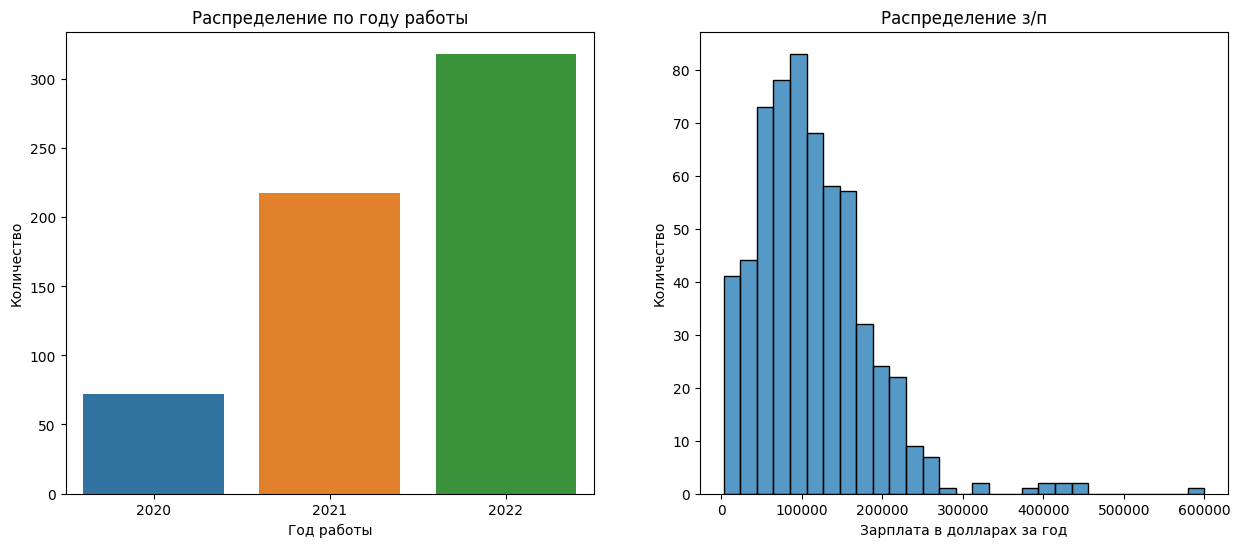

In [8]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (15, 6))
year_data = salary_data.groupby('work_year')['work_year'].count() #группируем данные по годам, для подсчета количества
sns.barplot(ax = ax[0], x = list(year_data.index), y = year_data.values)
sns.histplot(salary_data, ax = ax[1], x = 'salary_in_usd') #строим график распределение зарплат
ax[0].set(
    xlabel='Год работы',
    ylabel='Количество',
    title='Распределение по году работы')
ax[1].set(
    xlabel = 'Зарплата в долларах за год',
    ylabel = 'Количество',
    title = 'Распределение з/п'
)

Самое большое количество вакансий представлены за 2022 год. Среднее значение з/п 112297, а медиальное 101570, отличие на 10000 не сильно велико. Распределение з/п похоже на нормальное с небольшим скосом влево.

c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 0, 'Зарплата в долларах за год'),
 Text(0.5, 1.0, 'Распределение з/п')]

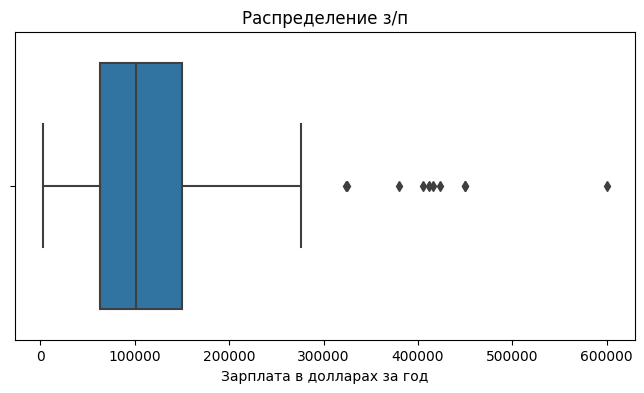

In [9]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
sns.boxplot(salary_data, x = 'salary_in_usd', ax = ax)
ax.set(
    xlabel = 'Зарплата в долларах за год',
    title = 'Распределение з/п'
)

Из этого графика видно, что выбросов в з/п довольно мало. В данном случае исключать их не будем, т. к. значения этих выбросов реальные и их немного. 

c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype i

<Axes: >

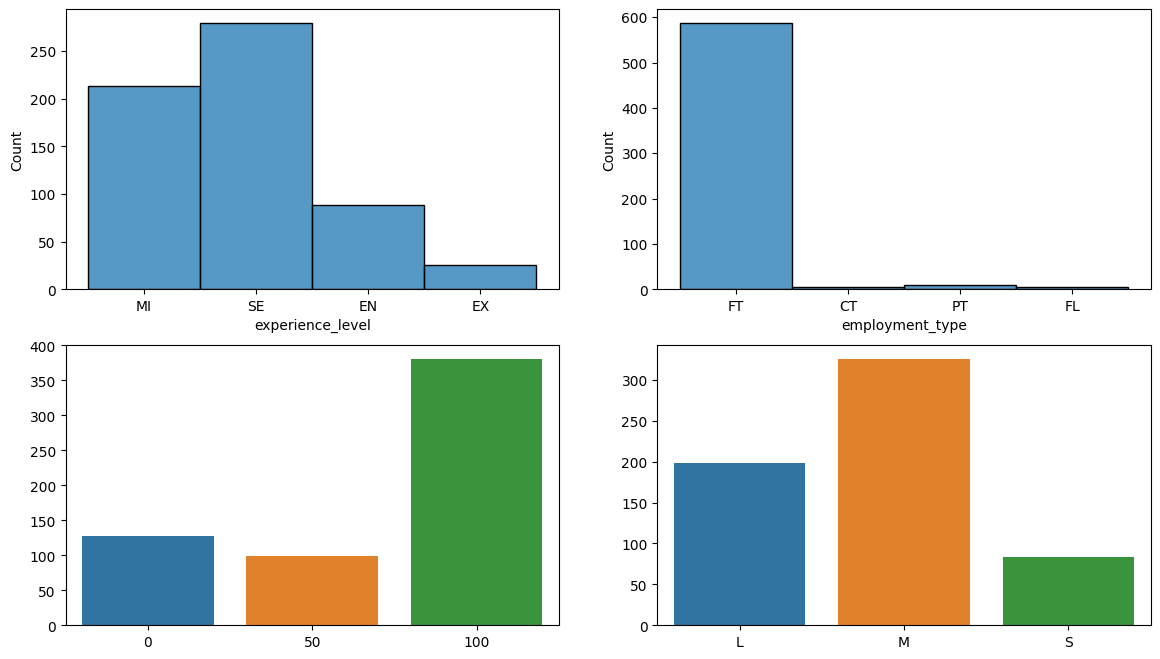

In [10]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (14, 8))

sns.histplot(salary_data, x = 'experience_level', ax = ax[0][0]) #гистограмма распределения вакансий по опыту работы
sns.histplot(salary_data, x = 'employment_type', ax = ax[0][1]) #гистограмма распределений вакансий по типу трудоустройства

rem_data = salary_data.groupby('remote_ratio')['remote_ratio'].count()
sns.barplot(x = list(rem_data.index), y = rem_data.values, ax = ax[1][0]) #столбчатая диаграмма распределения вакансий по кол-ву удаленной работы

comp_data = salary_data.groupby('company_size')['company_size'].count()
sns.barplot(x = list(comp_data.index), y = comp_data.values, ax = ax[1][1]) #столбчатая диаграмма распределения вакансий по размеру компании

Из этих графиков видно, что у специалистов в сфере Data Science преобладает полный рабочий день, так как в больших проектах очень много задач, короткие сроки выполнения => работа ведется практически непрерывно. Довольно много вакансий в которых объем выполняемой работы удаленно более 80%, удаленка для программистов с каждым годом набирает все большую популярность.

Далее заменим названия стран в таблице со стандарта Alpha-2ISO 3166-1 на Alpha-3ISO 3166-1, для того чтобы построить карту распределения стран проживания работников и расположения офисов.

In [11]:
url = 'https://ru.wikipedia.org/wiki/ISO_3166-1'
page = requests.get(url)

soup = BeautifulSoup(page.text, 'html.parser')

table1 = soup.find('table', class_ = 'wikitable sortable') #находим таблицу на сайте

headers = [] #создаем массив заголовков столбцов таблицы
for i in table1.find_all('th'):
    title = i.text
    headers.append(title) #заполняем массив заголовков
print(headers)
mydata = pd.DataFrame(columns = headers)
for j in table1.find_all('tr')[1:]: #перебираем все строки
    row_data = j.find_all('td')
    row = [i.text for i in row_data]
    length = len(mydata)
    mydata.loc[length] = row #заполняем нашу таблицу строками
country_data_utf = mydata[['Alpha-3ISO 3166-1', 'Страна']]
mydata = mydata[['Alpha-2ISO 3166-1', 'Alpha-3ISO 3166-1']] #оставляем только два необходимых столбца
print(mydata[['Alpha-2ISO 3166-1', 'Alpha-3ISO 3166-1']])

['Страна', 'Alpha-2ISO 3166-1', 'Alpha-3ISO 3166-1', 'ЦифровойISO 3166-1', 'кодISO 3166-2\n']
    Alpha-2ISO 3166-1 Alpha-3ISO 3166-1
0                  AU               AUS
1                  AT               AUT
2                  AZ               AZE
3                  AX               ALA
4                  AL               ALB
..                ...               ...
245                ZA               ZAF
246                GS               SGS
247                SS               SSD
248                JM               JAM
249                JP               JPN

[250 rows x 2 columns]


In [12]:
salary_data = salary_data.merge(mydata, how = 'left', left_on = 'employee_residence', right_on = 'Alpha-2ISO 3166-1')
# объединяем исходный датафрейм с полученным по месту работы сотрудников
salary_data = salary_data.drop(labels = ['employee_residence', 'Alpha-2ISO 3166-1'], axis = 1) #удаляем лишние столбцы
salary_data = salary_data.rename(columns = {'Alpha-3ISO 3166-1' : 'employee_residence'})

salary_data = salary_data.merge(mydata, how = 'left', left_on = 'company_location', right_on = 'Alpha-2ISO 3166-1')
# объединяем исходный датафрейм с полученным по месту расположения офиса компании
salary_data = salary_data.drop(labels = ['company_location', 'Alpha-2ISO 3166-1'], axis = 1)
salary_data = salary_data.rename(columns = {'Alpha-3ISO 3166-1' : 'company_location'})
#строим карты распределения проживания сотрудников и расположения офисов
comp_data = pd.DataFrame(salary_data['company_location'].value_counts().reset_index().rename(columns={"index": "company_location", 0: "count1"}))
emp_data = pd.DataFrame(salary_data['employee_residence'].value_counts().reset_index().rename(columns={"index": "employee_residence", 0: "count2"}))
choropleth_data = pd.concat([comp_data, emp_data], axis = 1)
choropleth_data.columns = ['company_location', 'count1', 'employee_residence', 'count2']

In [13]:
fig = px.choropleth(
    data_frame=choropleth_data, #DataFrame
    locations="employee_residence", #столбец с локациями
    locationmode = "ISO-3", #режим сопоставления локаций с базой Plotly
    color="count2", #от чего зависит цвет
    range_color=[0, 400], #диапазон цвета
    title='Распределение стран проживания работников', #заголовок
    width=800, #ширина
    height=500, #высота
    color_continuous_scale='Reds' #палитра цветов
)

plotly.io.write_html(fig, 'graphs\\employee_residence.html')
fig.show()

fig = px.choropleth(
    data_frame=choropleth_data, #DataFrame
    locations="company_location", #столбец с локациями
    locationmode = "ISO-3", #режим сопоставления локаций с базой Plotly
    color="count1", #от чего зависит цвет
    range_color=[0, 400], #диапазон цвета
    title='Распределение расположения головных офисов компаний', #заголовок
    width=800, #ширина
    height=500, #высота
    color_continuous_scale='Reds' #палитра цветов
)

plotly.io.write_html(fig, 'graphs\\company_location.html')
fig.show()

In [14]:
year_data = pd.DataFrame(salary_data.groupby('work_year')['salary_in_usd'].mean().reset_index().rename(columns = {'index': 'work_year', 0: 'salary_in_usd'}))

fig = px.line(data_frame = year_data, x = 'work_year', y = 'salary_in_usd')
fig.update_layout(
    title_text = 'Изменение средней з/п в течении трех лет'
)

plotly.io.write_html(fig, 'graphs\\salary_by_year.html')
fig.show()

Из этого графика видно, что с 2020 на 2021 год средняя з/п выросла незначительно, а вот с 2021 на 2022 виден сильный рост.

Далее построим крафики средней з/п в завиимости от опыта работы; типа трудоустройства; объема работы, выполняемой удаленно и размера компании.

In [15]:
#строим вспомогательные таблицы для получения распределения уровня средней з/п по опыту работы, типу трудоустройства, кол-ву удаленной работы и размеру компании
exp_data = pd.DataFrame(salary_data.groupby('experience_level')['salary_in_usd'].mean().reset_index().rename(columns = {'index': 'experience_level', 0: 'salary_in_usd'}))
emp_data = pd.DataFrame(salary_data.groupby('employment_type')['salary_in_usd'].mean().reset_index().rename(columns = {'index': 'employment_type', 0: 'salary_in_usd'}))
rem_data = pd.DataFrame(salary_data.groupby('remote_ratio')['salary_in_usd'].mean().reset_index().rename(columns = {'index': 'remote_ratio', 0: 'salary_in_usd'}))
comp_data = pd.DataFrame(salary_data.groupby('company_size')['salary_in_usd'].mean().reset_index().rename(columns = {'index': 'company_size', 0: 'salary_in_usd'}))
# аналогичные таблицы для распределений, но уже в разрезе должностей
pivot_exp = pd.pivot_table(salary_data, index = 'experience_level', columns = 'job_title', values = 'salary_in_usd', aggfunc='mean')
pivot_emp = pd.pivot_table(salary_data, index = 'employment_type', columns = 'job_title', values = 'salary_in_usd', aggfunc='mean')
pivot_rem = pd.pivot_table(salary_data, index = 'remote_ratio', columns = 'job_title', values = 'salary_in_usd', aggfunc='mean')
pivot_size = pd.pivot_table(salary_data, index = 'company_size', columns = 'job_title', values = 'salary_in_usd', aggfunc='mean')

In [16]:
fig = make_subplots(rows=2, #создаем плоскость для графиков
                    cols=2, 
                    column_widths=[1, 1], 
                    subplot_titles=("Зависомость средней з/п от опыта работы", 
                                    "Зависомость средней з/п от типа трудоустройства",
                                    "Зависомость средней з/п от кол-ва удаленной работы",
                                    "Зависомость средней з/п от размера компании"))
# добавляем графики распределений по первым 4-м таблицам из предыдущего блока
fig.add_trace(go.Bar(x=exp_data['experience_level'], y=exp_data['salary_in_usd'], name = 'exp_l'), 1, 1)
fig.add_trace(go.Bar(x=emp_data['employment_type'], y=emp_data['salary_in_usd'], name = 'type'), 1, 2)
fig.add_trace(go.Bar(x=rem_data['remote_ratio'], y=rem_data['salary_in_usd'], name = 'distant'), 2, 1)
fig.add_trace(go.Bar(x=comp_data['company_size'], y=comp_data['salary_in_usd'], name = 'size'), 2, 2)

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  hovermode="x",
                  margin=dict(l=30, r=30, t=20, b=0),
                  height = 500)

plotly.io.write_html(fig, 'graphs\\defaul_distribution.html')
fig.show()

Из этих графиков видно, что чем выше опыт работников, тем выше заработная плата.  
Вакансии по контракту предлагают самую высокую оплату, примерно на 40% меньше получают сотрудники, работающие полный день.  
В больших и средних компаниях з/п практически не отличается, а вот в маленьких на процентов тридцать меньше.  
В зависимости от количества выполняемой работы удаленно трудно определить зависимость.

In [17]:
# строим тепловые карты для распределений по вторым 4-м таблицам из предыдущего блока
fig = px.imshow(pivot_exp)
fig.update_layout(
    title_text = 'Размер средней з/п от опыта работы по должностям'
)
plotly.io.write_html(fig, 'graphs\\exp_level_salary.html')
fig.show()

fig = px.imshow(pivot_emp)
fig.update_layout(
    title_text = 'Размер средней з/п от типа трудоустройства работы по должностям'
)
plotly.io.write_html(fig, 'graphs\\employment_salary.html')
fig.show()

fig = px.imshow(pivot_rem)
fig.update_layout(
    title_text = 'Размер средней з/п от кол-ва удаленной работы работы по должностям'
)
plotly.io.write_html(fig, 'graphs\\remotion_salary.html')
fig.show()

fig = px.imshow(pivot_size)
fig.update_layout(
    title_text = 'Размер средней з/п от размера компании работы по должностям'
)
plotly.io.write_html(fig, 'graphs\\size_salary.html')
fig.show()

Те же самые зависимости, но уже в разрезе должностей не дают особо новой информации. Видно, что для большинства наименований присутсвуют вакансии только на полный рабочий день и отсутсвую вакансии для начинающих специалистов.

In [18]:
re1 = 'Data Scientist'
re2 = 'Data Engineer'
# функции для нахождения профессий Data Scientist и Data Engineer
def find_scient(line):
    if (line.find(re1) != -1):
        return True
    else:
        return False
def find_engineer(line):
    if (line.find(re2) != -1):
        return True
    else:
        return False
mask_scient = salary_data['job_title'].apply(find_scient)
mask_engineer = salary_data['job_title'].apply(find_engineer)

mask = salary_data['work_year'] == 2022
# отбираем данные для Data Scientisc и Data Engineer за 2022 год
scient_data_ = salary_data[mask_scient & mask]
engineer_data_ = salary_data[mask_engineer & mask]

print('Средняя з/п Data Science в 2022-ом году: ', scient_data_['salary_in_usd'].mean())
print('Средняя з/п Data Engineer в 2022-ом году: ', engineer_data_['salary_in_usd'].mean())
# создаем таблицы для распределения з/п этих двух профессий
scient_data = pd.DataFrame(scient_data_.groupby('job_title')['salary_in_usd'].mean().reset_index().rename(columns = {'index': 'job_title', 0: 'salary_in_usd'}))
engineer_data = pd.DataFrame(engineer_data_.groupby('job_title')['salary_in_usd'].mean().reset_index().rename(columns = {'index': 'job_title', 0: 'salary_in_usd'}))

fig = make_subplots(rows=1, cols=2, column_widths=[1, 1], subplot_titles=("Средняя з/п Data Science", "Средня з/п Data Engineer"))

fig.add_trace(go.Bar(x=scient_data['job_title'], y=scient_data['salary_in_usd'], name = 'sd'), 1, 1)
fig.add_trace(go.Bar(x=engineer_data['job_title'], y=engineer_data['salary_in_usd'], name = 'sd'), 1, 2)

plotly.io.write_html(fig, 'graphs\\mean_data_engineer.html')
fig.show()

Средняя з/п Data Science в 2022-ом году:  140270.67901234567
Средняя з/п Data Engineer в 2022-ом году:  126284.71111111112


Средняя з/п специалисто в сфере Data Science и Data Engineer отличаются незначительно. 

In [19]:
print(list(salary_data['job_title']))
# функция для разбиения специальностей на 7 групп
# Director Scientist Engineer Consultant Manager Analyst Researcher
def refact_job(line):
    if line.find('Director') != -1:
        return 'Director'
    elif line.find('Engineer') != -1:
        return 'Engineer'
    elif line.find('Scientist') != -1:
        return 'Scientist'
    elif line.find('Consultant') != -1:
        return 'Consultant'
    elif line.find('Manager') != -1:
        return 'Manager'
    elif line.find('Analyst') != -1:
        return 'Analyst'
    elif line.find('Researcher') != -1:
        return 'Researcher'
    
ref_job = salary_data['job_title'].apply(refact_job)
salary_data['ref_job'] = ref_job
job_salary = salary_data.groupby('ref_job')['salary_in_usd'].mean().reset_index().rename(columns = {'index': 'job_title', 0: 'salary_in_usd'})
job_salary = job_salary.sort_values(by = 'salary_in_usd', ascending = False)
print(job_salary)
# строим график распределения средней зарплаты для каждой группы
fig = px.bar(job_salary, x = 'ref_job', y = 'salary_in_usd')
fig.update_layout(
    title_text = 'Средняя з/п в зависимоти от должности'
)
plotly.io.write_html(fig, 'graphs\\job_title_salary.html')
fig.show()

['Data Scientist', 'Machine Learning Scientist', 'Big Data Engineer', 'Product Data Analyst', 'Machine Learning Engineer', 'Data Analyst', 'Lead Data Scientist', 'Data Scientist', 'Business Data Analyst', 'Lead Data Engineer', 'Data Scientist', 'Data Scientist', 'Data Scientist', 'Lead Data Analyst', 'Data Analyst', 'Data Analyst', 'Data Engineer', 'Big Data Engineer', 'Data Science Consultant', 'Lead Data Engineer', 'Machine Learning Engineer', 'Product Data Analyst', 'Data Engineer', 'BI Data Analyst', 'Lead Data Scientist', 'Director of Data Science', 'Research Scientist', 'Data Engineer', 'Business Data Analyst', 'Machine Learning Manager', 'Data Engineering Manager', 'Big Data Engineer', 'Data Scientist', 'Research Scientist', 'Data Analyst', 'Data Engineer', 'Data Science Consultant', 'Machine Learning Engineer', 'Data Analyst', 'Machine Learning Engineer', 'Data Scientist', 'Data Engineering Manager', 'Machine Learning Infrastructure Engineer', 'Data Engineer', 'Data Engineer', 

Из этого графика видно, что руководители получают больше всего, за ними идут менеджеры, далее примерно на одном уровне Data Scientist и Data Engineer. Меньше них получают аналитики и консультанты и в данных представлена всего одна должность исследователя с самой низкой з/п из всех.

# Статистические тесты

Мы хотим проверить, изменилась ли медиана заработной платы за 2020, 2021 и 2022 года.  
Сформулируем гипотезы в математическом виде:  
* Нулевая гипотеза: медианы заработной платы за 2020($m_{1}$), 2021($m_{2}$) и 2022($m_{3}$) года равны.  
    $H_{0}$ : $m_{1} = m_{2} = m_{3}$  
* Альтернативная гипотеза: медианы заработной платы за 2020($m_{1}$), 2021($m_{2}$) и 2022($m_{3}$) года не равны.  
    $H_{1} : m_{1} \not{=}  m_{2} \not{=}  m_{3}$

In [20]:
data_2020 = list(salary_data[salary_data['work_year'] == 2020]['salary_in_usd'])
data_2021 = list(salary_data[salary_data['work_year'] == 2021]['salary_in_usd'])
data_2022 = list(salary_data[salary_data['work_year'] == 2022]['salary_in_usd'])

alpha = 0.05
# проверяем данные на нормальность
_, p1 = stats.shapiro(data_2020)
_, p2 = stats.shapiro(data_2021)
_, p3 = stats.shapiro(data_2022)

if p1 <= alpha: print('Распределение данных за 2020-й год не нормальное')
else: print('Распределение данных за 2020-й год нормальное')
if p1 <= alpha: print('Распределение данных за 2021-й год не нормальное')
else: print('Распределение данных за 2021-й год нормальное')
if p1 <= alpha: print('Распределение данных за 2022-й год не нормальное')
else: print('Распределение данных за 2022-й год нормальное')

Распределение данных за 2020-й год не нормальное
Распределение данных за 2021-й год не нормальное
Распределение данных за 2022-й год не нормальное


In [21]:
_, p = stats.kruskal(data_2020, data_2021, data_2022) # проверяем гипотезу

print('p-value = {}'.format(p))

if p <= alpha:
    print('p-value меньше заданного alpha => отвергаем нулевую гипотезу')
else:
    print('p-value больше заданного alpha => нет оснований отвергнуть нулевую гипотезу')

p-value = 7.132756674842484e-11
p-value меньше заданного alpha => отвергаем нулевую гипотезу


**Вывод:** медиана заработной платы за три года различна.

Теперь мы хотим проверить, наблюдался ли рост зарплат за прошедшие три года.  
Сформулируем гипотезы в математичесеком виде:  
* 1-я гипотеза:
    + Нулевая гипотеза: средняя заработная плата за 2020($m_{1}$) и 2021($m_{2}$) одинаковы.  
        $H_{0}$ : $m_{1} = m_{2}$
    + Альтернативная гипотеза: средняя заработная плата за 2020($m_{1}$) меньше, чем за 2021($m_{2}$).  
        $H_{1}$ : $m_{1} < m_{2}$
* 2-я гипотеза:
    + Нулевая гипотеза: средняя заработная плата за 2021($m_{2}$) и 2022($m_{3}$) одинаковы.  
        $H_{0}$ : $m_{2} = m_{3}$
    + Альтернативная гипотеза: средняя заработная плата за 2021($m_{2}$) меньше, чем за 2022($m_{3}$).  
        $H_{1}$ : $m_{2} < m_{3}$

In [22]:
_, p1 = stats.mannwhitneyu(data_2020, data_2021, alternative = 'less')
_, p2 = stats.mannwhitneyu(data_2021, data_2022, alternative = 'less')

print('p1-value = {}'.format(p1))
print('p2-value = {}'.format(p2))

if p1 <= alpha:
    print('p-value меньше заданного alpha => отвергаем первую нулевую гипотезу')
else:
    print('p-value больше заданного alpha => нет оснований отвергнуть первую нулевую гипотезу')

if p2 <= alpha:
    print('p-value меньше заданного alpha => отвергаем вторую нулевую гипотезу')
else:
    print('p-value больше заданного alpha => нет оснований отвергнуть вторую нулевую гипотезу')

p1-value = 0.23222339933904124
p2-value = 2.169397430953088e-09
p-value больше заданного alpha => нет оснований отвергнуть первую нулевую гипотезу
p-value меньше заданного alpha => отвергаем вторую нулевую гипотезу


**Вывод:** с 2020 к 2021 году не наблюдался рост з/п, а от 2021 к 2022 рост зарплат был.

Проверим как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году.  
Сформулируем математические гипотезы:  
* Нулевая гипотеза: средняя заработная плата Data Scientist($m_{1}$) и Data Engineer($m_{2}$) одинаковы.  
    $H_{0}$ : $m_{1} = m_{2}$
* Альтернативная гипотеза: средняя заработная плата Data Scientist($m_{1}$) больше средней з/п Data Engineer($m_{2}$).  
    $H_{1}$ : $m_{1} > m_{2}$

In [23]:
data_scientist = list(scient_data_['salary_in_usd'])
data_engineer = list(engineer_data_['salary_in_usd'])
# проверяем данные на нормальность
_, p1 = stats.shapiro(data_scientist)
_, p2 = stats.shapiro(data_engineer)

if p1 <= alpha: print('Распределение данных зарплат Data Scientist не нормальное')
else: print('Распределение данных зарплат Data Scientist нормальное')
if p2 <= alpha: print('Распределение данных зарплат Data Engineer не нормальное')
else: print('Распределение данных зарплат Data Engineer нормальное')

Распределение данных зарплат Data Scientist не нормальное
Распределение данных зарплат Data Engineer не нормальное


In [24]:
_, p = stats.mannwhitneyu(data_scientist, data_engineer, alternative = 'greater') # проверяем гипотезу

print('p-value = {}'.format(p))

if p <= alpha:
    print('p-value меньше заданного alpha => отвергаем нулевую гипотезу')
else:
    print('p-value больше заданного alpha => нет оснований отвергнуть нулевую гипотезу')

p-value = 0.03813119389743546
p-value меньше заданного alpha => отвергаем нулевую гипотезу


**Вывод:** средняя з/п у специалисто в сфере Data Science больше, чем у Data Engineer.

Теперь хотелось бы ответить на еще один ключевой вопрос HR-агенства - это как соотносятся зарплаты специалистов Data Science в компаниях различных размеров?  
Сформулируем математические гипотезы:  
* Нулевая гипотеза: средняя заработная плата Data Scientist($m_{1}$) в средних компаниях больше или равна з/п Data Scientist($m_{2}$) в боьлших компаниях.  
    $H_{0}$ : $m_{1} \geq m_{2}$
* Альтернативная гипотеза: средняя заработная плата Data Scientist($m_{1}$) в средних компаниях меньше средней з/п Data Scientist($m_{2}$) в больших компаниях.  
    $H_{1}$ : $m_{1} < m_{2}$

In [25]:
mask_S = scient_data_['company_size'] == 'S'
mask_M = scient_data_['company_size'] == 'M'
mask_L = scient_data_['company_size'] == 'L'
# отбираем данные для компаний разных размеров
data_S = list(scient_data_[mask_S]['salary_in_usd'])
data_M = list(scient_data_[mask_M]['salary_in_usd'])
data_L = list(scient_data_[mask_L]['salary_in_usd'])

print(data_S)
print(data_M)
print(data_L)
# проверяем на нормальность
_, p1 = stats.shapiro(data_M)
_, p2 = stats.shapiro(data_L)

if p1 <= alpha: print('Распределение данных зарплат Data Scientist в средних компаниях не нормальное')
else: print('Распределение данных зарплат Data Scientist в средних компаниях нормальное')
if p2 <= alpha: print('Распределение данных зарплат Data Scientist в больших компаниях не нормальное')
else: print('Распределение данных зарплат Data Scientist в больших компаниях нормальное')

[48000]
[130000, 90000, 136620, 99360, 117789, 104702, 146000, 123000, 65438, 39263, 165220, 120160, 95550, 167000, 123000, 150000, 211500, 138600, 170000, 123000, 180000, 71982, 45807, 260000, 180000, 80000, 18442, 162674, 104890, 140000, 220000, 140000, 183228, 91614, 185100, 200000, 120000, 230000, 100000, 100000, 100000, 165000, 86703, 69336, 78000, 141300, 102100, 176000, 144000, 205300, 140400, 140000, 210000, 140000, 210000, 140000, 210000, 140000, 230000, 150000, 210000, 160000, 130000]
[180000, 120000, 215300, 158200, 140400, 215300, 31615, 35590, 52396, 40000, 157000, 122346, 380000, 135000, 177000, 205300, 140400]
Распределение данных зарплат Data Scientist в средних компаниях нормальное
Распределение данных зарплат Data Scientist в больших компаниях нормальное


In [26]:
_, p = stats.ttest_ind(data_M, data_L, alternative = 'less')

print('p-value = {}'.format(p))

if p <= alpha:
    print('p-value меньше заданного alpha => отвергаем нулевую гипотезу')
else:
    print('p-value больше заданного alpha => нет оснований отвергнуть нулевую гипотезу')


p-value = 0.3214370364660637
p-value больше заданного alpha => нет оснований отвергнуть нулевую гипотезу


**Вывод:** зарплаты в средних компаниях и больших особо не отличаются.

Стоит задача выяснить, усть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?  
Сформулируем математические гипотезы:  
* Нулевая гипотеза: признаки "наличие должностей Data Scientist и Data Engineer" и "размер компании" независимы
* Альтернативная гипотеза: признаки "наличие должностей Data Scientist и Data Engineer" и "размер компании" взаимосвязаны

In [27]:
mask_L = salary_data['company_size'] == 'L'
mask_M = salary_data['company_size'] == 'M'

arr_L = pd.Series((mask_scient | mask_engineer) & mask_L)
arr_M = pd.Series((mask_scient | mask_engineer) & mask_M)

table = pd.crosstab(arr_L, arr_M)

_, p, _, _ = stats.chi2_contingency(table)

print('p-value = {}'.format(p))

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


p-value = 1.7495252535529809e-12
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод:** признаки взаимосвязаны

In [28]:
a = list(range(600))

arr = np.random.choice(a, 200, replace = False)
arr_L_ = arr_L.iloc[arr]
arr = np.random.choice(a, 200, replace = False)
arr_M_ = arr_M.iloc[arr]

_, p, _, _ = stats.chi2_contingency(table)

table = pd.crosstab(arr_L_, arr_M_)

print('p-value = {}'.format(p))

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


p-value = 1.7495252535529809e-12
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Интересный факт, если сделать выборку из 200 элементов, то результат будет сильно отличаться

In [29]:
arr = np.random.choice(a, 150, replace = False)
arr_L_ = arr_L.iloc[arr]
arr = np.random.choice(a, 150, replace = False)
arr_M_ = arr_M.iloc[arr]

_, p, _, _ = stats.chi2_contingency(table)

table = pd.crosstab(arr_L_, arr_M_)

print('p-value = {}'.format(p))

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


p-value = 0.07661422037968442
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Если выборка из 150 элементов, то результат тот же => в этом случае не стоит полагаться на выборки, а следует анализировать как можно больший набор данных.

### 1-я гипотеза: уровень з/п зависит от страны, в которой располагается основной офис компании

In [30]:
country_data = pd.DataFrame(salary_data.groupby('company_location')['salary_in_usd'].mean().reset_index().rename(columns = {'index': 'company_locayion', 0: 'salary_in_usd'}))

country_data = country_data.merge(country_data_utf, how = 'left', left_on = 'company_location', right_on = 'Alpha-3ISO 3166-1')

fig = px.choropleth(
    data_frame=country_data, #DataFrame
    locations="company_location", #столбец с локациями
    locationmode = "ISO-3", #режим сопоставления локаций с базой Plotly
    color="salary_in_usd", #от чего зависит цвет
    range_color=[0, 170000], #диапазон цвета
    title='Средняя з/п по странам', #заголовок
    width=800, #ширина
    height=500, #высота
    color_continuous_scale='Reds' #палитра цветов
)

plotly.io.write_html(fig, 'graphs\\company_location_salary.html')
fig.show()

Прослеживается зависимость в уровне зарплаты в зависимости от развитости и размера страны, в которой расположен главный офис компании. Лидеры по размеру выплачиваемых денег оказались: Россия, США, Япония, Австралия, ОАЭ.  
Интересно, что в Китае и Германии платят специалистам в сфере Data Science вдвое меньше, чем в России и США.

Мы хотим проверить, одинаковы ли медианы значений з/п в России, Японии и Франции.  
Сформулируем гипотезы в математическом виде:  
* Нулевая гипотеза: медианы заработной платы во Франции($m_{1}$), России($m_{2}$) и Японии($m_{3}$) равны.  
    $H_{0}$ : $m_{1} = m_{2} = m_{3}$  
* Альтернативная гипотеза: медианы заработной платы во Франции($m_{1}$), России($m_{2}$) и Японии($m_{3}$) не равны.  
    $H_{1} : m_{1} \not{=}  m_{2} \not{=}  m_{3}$

In [31]:
# отбираем данные для трех стран
usa_data = salary_data[salary_data['company_location'] == 'USA']['salary_in_usd']
japan_data = salary_data[salary_data['company_location'] == 'JPN']['salary_in_usd']
france_data = salary_data[salary_data['company_location'] == 'FRA']['salary_in_usd']
# проверяем на нормальность
_, p1 = stats.shapiro(usa_data)
_, p2 = stats.shapiro(japan_data)
_, p3 = stats.shapiro(france_data)

if p1 <= alpha: print('Распределение данных для США не нормальное')
else: print('Распределение данных для США нормальное')
if p1 <= alpha: print('Распределение данных для Японии не нормальное')
else: print('Распределение данных для Японии нормальное')
if p1 <= alpha: print('Распределение данных для Франции не нормальное')
else: print('Распределение данных для Франции нормальное')

Распределение данных для США не нормальное
Распределение данных для Японии не нормальное
Распределение данных для Франции не нормальное


In [32]:
_, p = stats.kruskal(data_2020, data_2021, data_2022)

print('p-value = {}'.format(p))

if p <= alpha:
    print('p-value меньше заданного alpha => отвергаем нулевую гипотезу')
else:
    print('p-value больше заданного alpha => нет оснований отвергнуть нулевую гипотезу')

p-value = 7.132756674842484e-11
p-value меньше заданного alpha => отвергаем нулевую гипотезу


**Вывод:** заработные платы отличаются в зависимости от того, где располагается офис компании.

### 2-я гипотеза: зарплата зависит от типа трудоустройства в компании

In [33]:
emp_type_table = pd.pivot_table(
    salary_data, 
    index = 'work_year', 
    columns = 'employment_type', 
    values = 'salary_in_usd', 
    aggfunc = 'mean'
)

fig = go.Figure()
# строим диаграммы средней зарплаты по типу трудоустройства для трех лет
fig.add_trace(go.Bar(x = emp_type_table.columns, y = emp_type_table.iloc[0], name='2020'))
fig.add_trace(go.Bar(x = emp_type_table.columns, y = emp_type_table.iloc[1], name='2021'))
fig.add_trace(go.Bar(x = emp_type_table.columns, y = emp_type_table.iloc[2], name='2022'))

fig.update_layout(
    title_text = 'Зарплаты в зависимости от типа трудоустройства'
)

fig.show()

Уровень зарплат по контракту очень сильно меняется в зависимости от года. В 2020 средний уровень был 100000 далее достиг своего пика(и пика по всем типам) в 2021 - 263000, а в 2022 упал почти в самый низ 31800.  
Уровень зарплат у фрилансеров меняется несколько иначе 2020 год - 60к, 2021 - 16к, 2022 - 100к.  
Их сложно сравнивать, так как то по контракту больше платят, то фрилансерам.  
Стабильно держится уровень зарплат у вакансий с полным рабочим днем.  
А у вакансий с неполным рабочим днем наблюдается небольшой рост с 2020 на 2021 год и довольно сильный скачок с 2021 на 2022 год.
Сделать какой-то основательный вывод довольно затруднительно, из-за сильных скачков в зарплатах у фрилансеров и контрактников. Единственное что прослеживается, что з/п у полного рабочего дня всегда выше чем у неполного.

# Общий вывод по проекту

Проведя данное исследование, можно дать ответы на ключевые вопросы HR-агенства  
* 1. У зарплат специалистов Data Scientist наблюдается ежегодгый рост.
* 2. Средние з/п специалистов Data Scientist и Data Engineer практически не отличаются
* 3. Зарплаты в больших и средних компаниях слабо отличаются, но в маленьких несколько меньше, чем в больших и средних
* 4. Наблюдается связь между наличием должностей Data Scientist и Data Engineer и размером компании. В больших компаниях с большей вероятностью окажется должность Data Scientist и Data Engineer, нежели чем в компаниях меньшего размера.

После доп исследований стало ясно, что на уровень з/п влияет Страна, в которой компания Зарегестрирована. Тип трудоустройства тоже влияет на уровень зарплаты, но четкую зависимость определить затруднительно.